In [2]:
import pandas as pd 
import numpy as np
import datetime as dt
import seaborn as sn

data = './data/water.csv'
water = pd.read_csv(data, index_col=0)\
  
water.head()

,lat_deg,lon_deg,report_date,status_id,water_source,water_tech,facility_type,country_name,install_year,installer,pay,status
row_id,,,,,,,,,,,,
3957,8.073136,38.617037,04/06/2017,y,NaN,NaN,NaN,Ethiopia,NaN,Private-CRS,NaN,NaN
33512,7.373784,40.503824,08/04/2020,y,Protected Spring,NaN,Improved,Ethiopia,2019.0,WaterAid,NaN,NaN
35125,0.773458,34.929509,03/18/2015,y,Protected Shallow Well,NaN,Improved,Kenya,NaN,NaN,NaN,NaN
37760,0.780576,34.963640,03/18/2015,y,Borehole,NaN,Improved,Kenya,NaN,NaN,NaN,NaN
38118,0.779266,34.971120,03/18/2015,y,Protected Shallow Well,NaN,Improved,Kenya,NaN,NaN,NaN,NaN


In [3]:
water.rename(
  {'lat_deg':'lat',
  'lon_deg':'lon',
  'country_name':'country'}, axis=1, inplace=True)

In [4]:
uniques = {col:list(water[col].unique()) for col in water.columns[4:]}

print(uniques['water_tech']) # Includes both method and development company after '-'
print(uniques['country']) # Includes nan values and non-African countries: Peru, Dominican Republic, Timor-Leste

[nan, 'Hand Pump - India Mark', 'Mechanized Pump', 'Tapstand', 'Hand Pump', 'Kiosk', 'Hand Pump - Vergnet', 'Hand Pump - Nira', 'Hand Pump - Afridev', 'Rope and Bucket', 'Mechanized Pump - Solar', 'Hand Pump - Canzee', 'Hydram', 'Hand Pump - Kardia', 'Hand Pump - Consallen', 'Hand Pump - Inkar', 'Hand Pump - SWN 80', 'Hand Pump - Indus', 'Hand Pump - PB Mark II', 'Mechanized Pump - Diesel']
['Ethiopia', 'Kenya', 'Central African Republic', 'Uganda', 'Niger', 'Mozambique', 'Liberia', 'Peru', 'Swaziland', 'Sierra Leone', 'Zambia', 'Nigeria', 'Ghana', 'Burkina Faso', 'Zimbabwe', 'Madagascar', 'Tanzania', 'South Sudan', 'Mali', 'Rwanda', 'South Africa', nan, 'Dominican Republic', 'Burundi', 'Gambia', 'Congo - Kinshasa', 'Angola', 'Algeria', 'Namibia', 'Sudan', 'Congo - Brazzaville', 'Chad', 'Mauritania', 'Timor-Leste', 'Egypt']


In [5]:
water['report_date'] = pd.to_datetime(water['report_date'])
water[['water_tech','brand']] = water['water_tech'].str.split('-',expand=True)
water = water[~water['country'].isin(['Peru', 'Dominican Republic', 'Timor-Leste'])]
water = water[~water['country'].isna()]

<AxesSubplot: xlabel='install_year', ylabel='Count'>

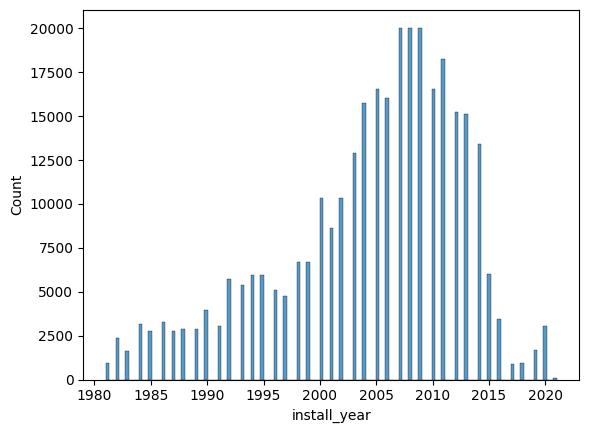

In [6]:
# sn.histplot(water['install_year']) # Includes years after 2021
water['install_year'] = np.where(water['install_year'] > 2021, np.nan, water['install_year'])

df = water[water['install_year'] > 1980]
sn.histplot(df['install_year'])

#### Creating a Map


In [25]:
import geopandas as gpd
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(water['lon'], water['lat'])]
gdf = gpd.GeoDataFrame(water, geometry=geometry)


In [33]:
world = gpd.read_file(
  gpd.datasets.get_path('naturalearth_lowres')
)
africa = world.query('continent == "Africa"')

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
11,86790567.0,Africa,Dem. Rep. Congo,COD,50400,"POLYGON ((29.34000 -4.49998, 29.51999 -5.41998..."
12,10192317.3,Africa,Somalia,SOM,4719,"POLYGON ((41.58513 -1.68325, 40.99300 -0.85829..."
13,52573973.0,Africa,Kenya,KEN,95503,"POLYGON ((39.20222 -4.67677, 37.76690 -3.67712..."
14,42813238.0,Africa,Sudan,SDN,30513,"POLYGON ((24.56737 8.22919, 23.80581 8.66632, ..."
15,15946876.0,Africa,Chad,TCD,11314,"POLYGON ((23.83766 19.58047, 23.88689 15.61084..."
25,58558270.0,Africa,South Africa,ZAF,351431,"POLYGON ((16.34498 -28.57671, 16.82402 -28.082..."
26,2125268.0,Africa,Lesotho,LSO,2376,"POLYGON ((28.97826 -28.95560, 29.32517 -29.257..."
48,14645468.0,Africa,Zimbabwe,ZWE,21440,"POLYGON ((31.19141 -22.25151, 30.65987 -22.151..."


<AxesSubplot: >

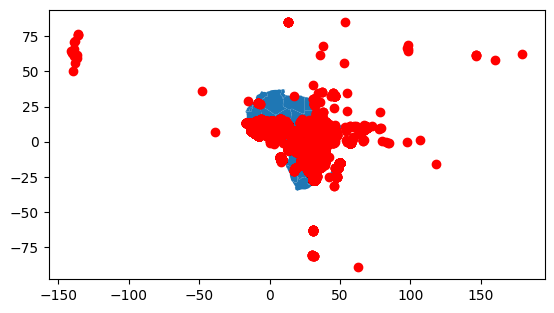

In [34]:
gdf.plot(ax=africa.plot(), marker = 'o', color='red')

A lot of erroneous points lying outside the actual continent. 

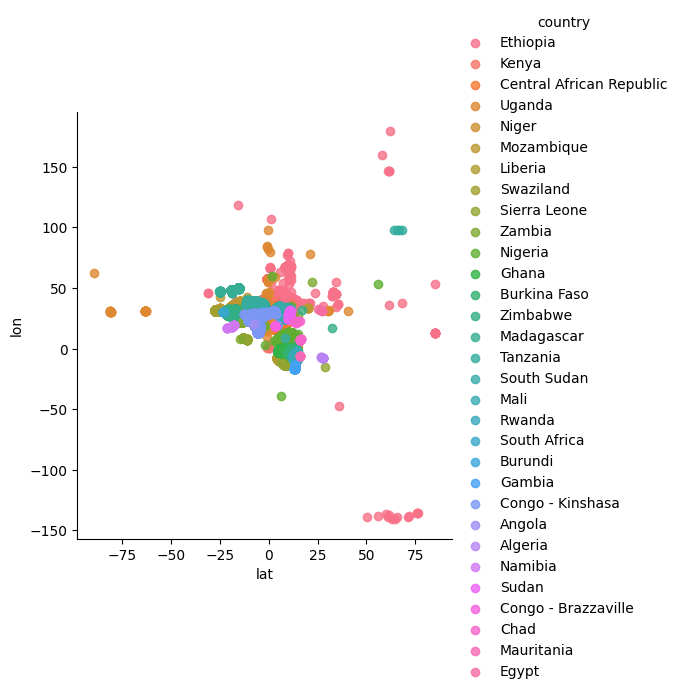

In [41]:
sn.lmplot(data=water, x='lat', y='lon', fit_reg=False, hue='country')

Hard to tell which countries these outlier points belong to based on these subtle differences in hues. Plotting the country name next to each point for more than 400k points is also not going to make things clear! 

We can, however, calculate the center of each country as the mean of all the coordinates located within that country, and then exclude points belonging to any country which lie outside a certain distance of its respective center. 

In [43]:
df = water[['country', 'lat', 'lon']].groupby('country').mean()


,lat,lon
country,,
Algeria,27.512962,-7.773892
Angola,-7.402311,20.055199
Burkina Faso,11.824792,-2.837905
Burundi,-3.155000,29.835000
Central African Republic,5.148619,17.160594
Chad,15.498707,12.942182
Congo - Brazzaville,3.092094,18.538947
Congo - Kinshasa,-2.988338,26.201318
Egypt,26.601359,31.670891
